These are my old simulations based on coupled envelopes...

## Nonlinear pulse propagation

From Hamerly's paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib import cm

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [2]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

## Single Pass

In [3]:
# def single_pass(a,b,Da,Db,epsilon,L,h,plot=False):
#     zi = 0
    
#     Da_h = Da**(h/2)
#     Db_h = Db**(h/2)
    
#     if plot==True:
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         plt.ion()
#         fig.canvas.draw()
        
#     while zi<L:
#         #Linear half step (front)
#         A = np.fft.fft(a)
#         A = A*Da
#         a = np.fft.ifft(A)
#         B = np.fft.fft(b)
#         B = B*Db
#         b = np.fft.ifft(B)
        
#         #Nonlinear step
#         #Runge-Kutta for a
#         ar = np.real(a)
#         ai = np.imag(a)
#         br = np.real(b)
#         bi = np.imag(b)
        
#         #Real part
#         k1 = h/2*epsilon*(br*ar + bi*ai)
#         k2 = h/2*epsilon*(br*(ar+k1/2) + bi*ai)
#         k3 = h/2*epsilon*(br*(ar+k2/2) + bi*ai)
#         k4 = h/2*epsilon*(br*(ar+k3) + bi*ai)
#         ar = ar + (1/6)*(k1+2*k2+2*k3+k4)
        
#         #Imaginary part
#         k1 = h/2*epsilon*(bi*ar - br*ai)
#         k2 = h/2*epsilon*(bi*ar - br*(ai+k1/2))
#         k3 = h/2*epsilon*(bi*ar - br*(ai+k2/2))
#         k4 = h/2*epsilon*(bi*ar - br*(ai+k3))
#         ai = ai + (1/6)*(k1+2*k2+2*k3+k4)

#         a = ar + 1j*ai
#         #Integral for b
#         b = b - 0.5*h*epsilon*a*a
        
#         #Runge-Kutta for a
#         ar = np.real(a)
#         ai = np.imag(a)
#         br = np.real(b)
#         bi = np.imag(b)
#         #Real part
#         k1 = h/2*epsilon*(br*ar + bi*ai)
#         k2 = h/2*epsilon*(br*(ar+k1/2) + bi*ai)
#         k3 = h/2*epsilon*(br*(ar+k2/2) + bi*ai)
#         k4 = h/2*epsilon*(br*(ar+k3) + bi*ai)
#         ar = ar + (1/6)*(k1+2*k2+2*k3+k4)
        
#         #Imaginary part
#         k1 = h/2*epsilon*(bi*ar - br*ai)
#         k2 = h/2*epsilon*(bi*ar - br*(ai+k1/2))
#         k3 = h/2*epsilon*(bi*ar - br*(ai+k2/2))
#         k4 = h/2*epsilon*(bi*ar - br*(ai+k3))
#         ai = ai + (1/6)*(k1+2*k2+2*k3+k4)

#         a = ar + 1j*ai
        
#         #Linear half step (back)
#         A = np.fft.fft(a)
#         A = A*Da
#         a = np.fft.ifft(A)
#         B = np.fft.fft(b)
#         B = B*Db
#         b = np.fft.ifft(B)
        
#         #Next z
#         zi = zi+h

#         if plot==True and zi%2<0.1:
#             ax.clear()
#             ax.plot(t, abs(a), t, abs(b));
#             ax.axes.set_ylim(0,2000)
#             fig.canvas.draw()
#             time.sleep(0.001)

#     return a,b

In [4]:
def single_pass(a,b,Da,Db,epsilon,L,h,plot=False):
    zi = 0
    
    Da_h = Da**(h/2)
    Db_h = Db**(h/2)
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
        
    while zi<L:
        #Linear half step (front)
        A = np.fft.fft(a)
        A = A*Da_h
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db_h
        b = np.fft.ifft(B)
        
        #Nonlinear step
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)

        #Integral for b
#         b = b - 0.5*h*epsilon*a*a
        b = b - h*epsilon*a*a
        
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        
        #Linear half step (back)
        A = np.fft.fft(a)
        A = A*Da_h
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db_h
        b = np.fft.ifft(B)
        
        #Next z
        zi = zi+h

        if plot==True and zi%2<0.1:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            fig.canvas.draw()
            time.sleep(0.001)

    return a,b

## OPO

In [5]:
def opo(wla=1.5, L=40, alpha = 0.00691,  u = 0.329, Tp = 13.2, b2a = 1.12e-4, 
        b3a = 3.09e-5, b2b = 4.06e-4, b3b = 2.51e-5, epsilon = 5.16e-5,
       G0 = 3.33, b0 = 3.84e2, p = 1.0, phi0=0, l=0, h=0.1, plot=False):
    
    #Initialize signal as random
    a = np.random.normal(0,1e-3,1024) + 1j*np.random.normal(0,1e-3,1024)
    a_prev = a

    #Linear operators
    Da = np.exp(-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)
    Db = np.exp(-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)
    
    #Feedback response
#     phi = phi0 + (phi0/pi)*(wla*1e-3)/(2*c)*Omega
    phi2 = 25
    phi3 = 76
    phi4 = -13020
    phi5 = 983328
    deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 #+ (phi4/24)*Omega**4 + (phi5/120)*Omega**5
    phi = phi0 + pi*l + l*(wla*1e-3)/(2*c)*Omega + deltaphi
    fb = np.sqrt(1/G0)*np.exp(-1j*phi)
    
    N = 500 #Max number of loops

    #Initialize convergence testing vector
    Vdiff = np.zeros((N,1))
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
    
    for kn in range(N):
        b = b0*p*b_shape
        a,b = single_pass(a,b,Da,Db,epsilon,L,h)

        #Power calc
        Pa = scipy.integrate.simps(np.abs(a)**2,t)
        Pa_prev = scipy.integrate.simps(np.abs(a_prev)**2,t)
#         Check if steady state at output of section
#         Pdiff = scipy.integrate.simps((np.abs(a_prev - a)**2),t)
#         diff = Pdiff/Pa*100
        diff = np.abs(Pa_prev - Pa)/Pa*100
        Vdiff[kn] = diff
        
        a_prev = a
        if diff<1e-6:
            break
            
        #Apply feedback
#         a = a*window
        A = np.fft.fft(a)
        A = A*fb
        a = np.fft.ifft(A)
        
        if plot==True and kn%2==0:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            ax.text(40,1400,'N=' + str(kn))
            ax.text(40,1200,'Pa=' + str(round(Pa*1e-8,3)))
            ax.text(40,1000,'diff=' + str(round(diff,6)))
            fig.canvas.draw()
            time.sleep(0.001)
        
    return a, Pa

# Tests

## Input parameters

In [6]:
#Input parameters
wla = 1.5 #um
wlb = wla/2 #um
L = 40 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5

p = 1.1 #normalized power
l = 0 #detuning

phi0 = pi*l

## Time and Frequency domain windows

In [7]:
#Simulation window setup
N = 1024 #Fourier size

#Let's base the window size on the pump duration
xtra = 5
t = np.linspace(-xtra*Tp, xtra*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')
window = np.hamming(N)

#Frequency domain
Omega = 2*pi*np.fft.fftfreq(t.size, ts) #Angular frequencies
print('Freq max =', np.amax(Omega), 'THz')

Sampling Rate = 0.12903225806451246 ps
Freq max = 24.299789660897133 THz


## Pump pulse shape

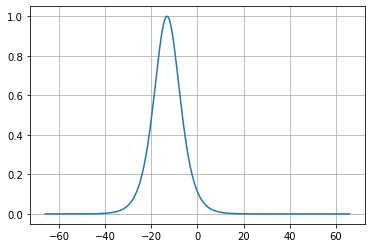

In [8]:
t0 = -Tp
tau = Tp/1.76
b_shape = 1/np.cosh((t-t0)/tau)**2

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.clear()
ax.plot(t,b_shape)
ax.grid()
fig.canvas.draw()

## Single Pass Test

In [9]:
# h = 0.1 #Distance step Size

# #Linear operators
# Da = np.exp(-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)
# Db = np.exp(-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)

# a = 500*b_shape
# # a = np.random.normal(0,1e-3,1024)
# b = b0*p*b_shape
# a,b = single_pass(a,b,Da,Db,epsilon,L,h,plot=True)

## OPO Test

In [10]:
# a, Pa = opo(l=-1.1, G0=1/0.35, p=2, h=0.5, plot=True)

In [11]:
# A = np.fft.fft(a)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.canvas.draw()
# ax.clear()
# ax.plot(Omega, np.abs(A))
# ax.grid()
# fig.canvas.draw()

## Sweep Detuning

In [ ]:
#Sweep detuning
# phi0 = np.arange(-0.3,0.3,0.05)
# l = np.arange(-0.1,0.1,0.01)
l = np.arange(-1.5,1.5,0.02)

a_sweep = np.zeros((l.size,N), dtype=complex)

# # 
for k in range(l.size):
    a_sweep[k,:], Pa = opo(l=l[k], p=2, G0=1/0.35, h=0.5, plot=False)
    
    pc = str(((k+1)/l.size)*100) + '% complete'
    print('l = ' + str(round(l[k],5)) + ' done; ' + pc)
    

l = -1.5 done; 0.6666666666666667% complete
l = -1.48 done; 1.3333333333333335% complete
l = -1.46 done; 2.0% complete
l = -1.44 done; 2.666666666666667% complete
l = -1.42 done; 3.3333333333333335% complete
l = -1.4 done; 4.0% complete
l = -1.38 done; 4.666666666666667% complete
l = -1.36 done; 5.333333333333334% complete
l = -1.34 done; 6.0% complete
l = -1.32 done; 6.666666666666667% complete
l = -1.3 done; 7.333333333333333% complete
l = -1.28 done; 8.0% complete
l = -1.26 done; 8.666666666666668% complete
l = -1.24 done; 9.333333333333334% complete
l = -1.22 done; 10.0% complete
l = -1.2 done; 10.666666666666668% complete
l = -1.18 done; 11.333333333333332% complete
l = -1.16 done; 12.0% complete
l = -1.14 done; 12.666666666666668% complete
l = -1.12 done; 13.333333333333334% complete
l = -1.1 done; 14.000000000000002% complete
l = -1.08 done; 14.666666666666666% complete
l = -1.06 done; 15.333333333333332% complete
l = -1.04 done; 16.0% complete
l = -1.02 done; 16.666666666666664

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.clear()

Spectrum = np.zeros(a_sweep.shape)

for k in range(l.size):
    A = np.fft.fft(a_sweep[k,:])
    Spectrum[k,:] = np.abs(A)**2
#     Spectrum[k,:] = 20*np.log10(np.abs(A))

Amax = np.amax(Spectrum)
Spectrum_dB = 10*np.log10(Spectrum/Amax)
# ax.imshow(np.fft.fftshift(Spectrum_dB), extent=(-0.4,0.4,-0.4,0.4));
ax.imshow(np.fft.fftshift(Spectrum_dB));